In [155]:
import os
import audioop
from scipy.io import wavfile
import numpy
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from convert import convert

In [156]:
audio_dir = "/Users/vladislao/Downloads/genres/"

In [230]:
genres = []
files = []


for dirname, dirnames, filenames in os.walk(audio_dir):
    
    for subdirname in dirnames:
        genres.append(subdirname)
    
    filenames = [os.path.join(dirname, filename) for filename in filenames if filename != ".DS_Store"]
    files.append(filenames[0:1])

    
files = files[1:]

In [231]:
raw_samples = []
rate = None
for file_group in files:
    raw_sample_group = []
    for file in file_group:
        converted = convert(file, "au")

        rate, X = wavfile.read(converted)
        raw_sample_group.append((rate, X))
    raw_samples.append(raw_sample_group)

In [232]:
%%capture

num = 0
for raw_sample_group in raw_samples:
    for rate, X in raw_sample_group:
        
        plt.figure(1 + num)
        plt.title(genres[num])
        plt.specgram(X, Fs=rate, xextent=(0,30))
        num += 1

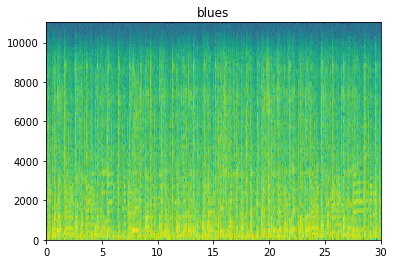

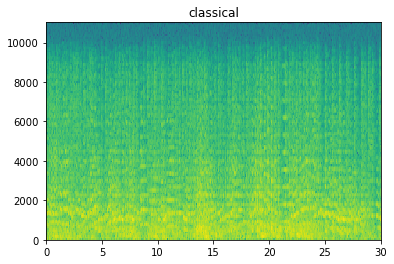

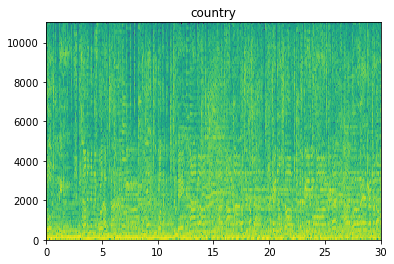

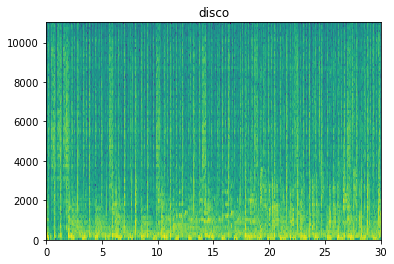

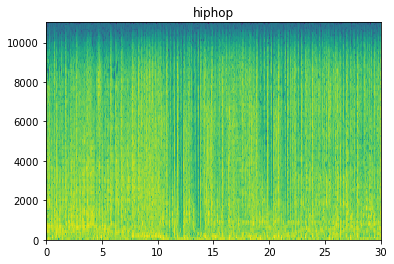

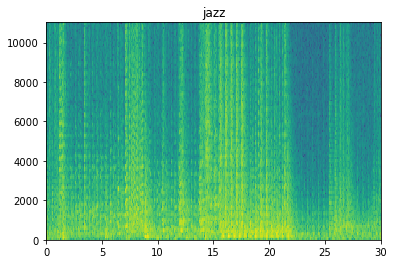

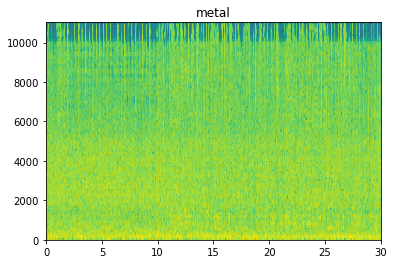

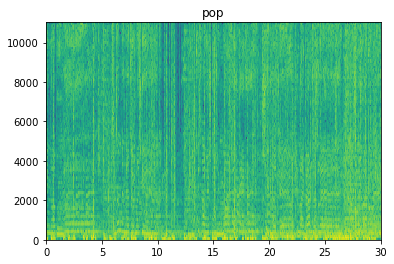

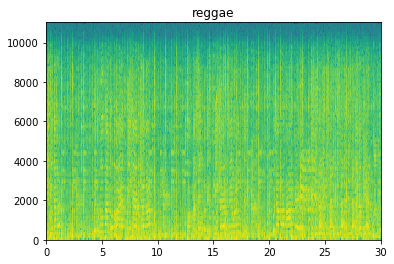

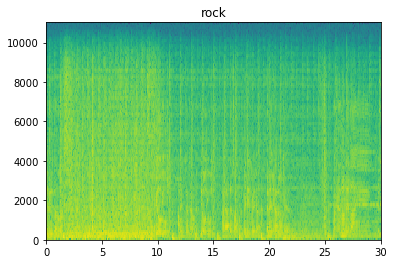

In [233]:
plt.show()

In [234]:
%%capture
rate, x = raw_samples[0][0]

window_size = int(rate * 0.1)
step_size = int(window_size * 0.8)

plt.figure(1)
plt.title("window 1")
plt.specgram(x[:window_size], Fs=window_size, xextent=(0,0.1))

plt.figure(2)
plt.title("window 2")
plt.specgram(x[step_size:window_size+step_size], Fs=window_size, xextent=(0.08,0.18))

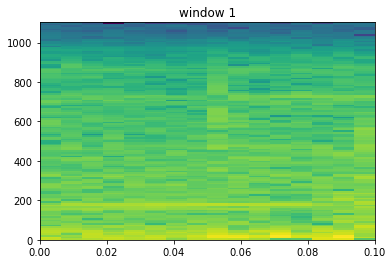

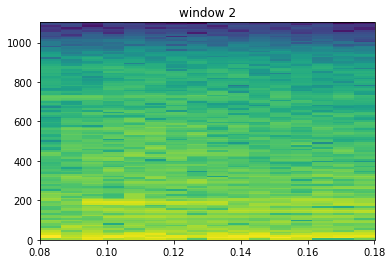

In [235]:
plt.show()

In [236]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(genres)
encoded_Y = encoder.transform(genres)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [245]:
window_size = int(rate * 0.1)
step_size = int(window_size * 0.8)

X = []
Y = []
for idx, raw_sample_group in enumerate(raw_samples):
    for rate, x in raw_sample_group:
        x = x.astype(float)
        x += 32000
        x /= 64000
        x = numpy.array([x[start:start + window_size].reshape(-1, 1) for start in range(0, x.shape[0] - window_size, step_size)])
        y = numpy.full((x.shape[0], dummy_y.shape[0]), dummy_y[idx])

        X.append(x)
        Y.append(y)

X = numpy.concatenate(X, axis=0)
Y = numpy.concatenate(Y, axis=0)

print(X.shape, Y.shape)

(3743, 2205, 1) (3743, 10)


In [246]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [249]:
batch_size = 25
epochs = 40

In [250]:
model = Sequential()
model.add(Conv1D(32, 
                 kernel_size=5,
                 activation='relu',
                 strides=2,
                 input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32,
                 3, 
                 strides=2,
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(32, 
#                  3, 
#                  activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25, seed=42))
# ?
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(x_test, y_test),
)

Train on 2807 samples, validate on 936 samples
Epoch 1/40
5s - loss: 2.2681 - acc: 0.1347 - val_loss: 2.1294 - val_acc: 0.1859
Epoch 2/40
4s - loss: 2.0529 - acc: 0.2212 - val_loss: 1.9976 - val_acc: 0.2532
Epoch 3/40
4s - loss: 1.8696 - acc: 0.3000 - val_loss: 1.7614 - val_acc: 0.3429
Epoch 4/40
4s - loss: 1.7515 - acc: 0.3399 - val_loss: 1.6775 - val_acc: 0.3654
Epoch 5/40
4s - loss: 1.6387 - acc: 0.3929 - val_loss: 1.6462 - val_acc: 0.3729
Epoch 6/40
4s - loss: 1.5271 - acc: 0.4214 - val_loss: 1.4815 - val_acc: 0.4167
Epoch 7/40
4s - loss: 1.4498 - acc: 0.4642 - val_loss: 1.4997 - val_acc: 0.4263
Epoch 8/40
3s - loss: 1.3921 - acc: 0.4902 - val_loss: 1.4265 - val_acc: 0.4306
Epoch 9/40
4s - loss: 1.3259 - acc: 0.5077 - val_loss: 1.5000 - val_acc: 0.4199
Epoch 10/40
4s - loss: 1.2788 - acc: 0.5233 - val_loss: 1.4130 - val_acc: 0.4466
Epoch 11/40
4s - loss: 1.2212 - acc: 0.5536 - val_loss: 1.3898 - val_acc: 0.4519
Epoch 12/40
4s - loss: 1.1390 - acc: 0.5850 - val_loss: 1.2857 - val_ac

In [251]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.15260851179
Test accuracy: 0.559829059829


In [253]:
print(numpy.mean(model.predict(X[0:375], batch_size=32, verbose=0), axis=0))
print(numpy.mean(model.predict(X[375:750], batch_size=32, verbose=0), axis=0)) 

[  7.90558577e-01   5.43285627e-03   1.89608394e-03   5.11321202e-02
   3.01791006e-04   3.88650633e-02   3.24944337e-03   3.81508539e-03
   4.90769818e-02   5.56720868e-02]
[  7.29068881e-03   6.22197926e-01   5.33151440e-03   1.23753063e-02
   1.60264826e-05   2.77683854e-01   3.60580898e-08   2.51526758e-03
   1.29255075e-02   5.96640371e-02]


In [140]:
model.save('first')